# 3x3 assembly inputfile that: 

### Import module/Set up XS path/Create openMC model/Clean directory

In [220]:
import sys
import os 
import openmc
import numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs
import pandas as pd
from IPython.display import Image
import glob

### Ragusa environnement

import os

# Add path to OpenMC binary
# os.environ['PATH'] += r':/path/to/openmc/bin'
os.environ['PATH'] += r':/Users/jean.ragusa/repo/openmc/local/bin'

# Add location of OpenMC xs data
%env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/endfb-viii.0-hdf5/cross_sections.xml
# %env OPENMC_CROSS_SECTIONS=/Users/jean.ragusa/repo/nndc_hdf5/cross_sections.xml

### Pablo environnement

In [221]:
%env OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml
model=openmc.Model()

clean_file_list = ["model.xml", "materials.xml", "geometry.xml","plots.xml","geometry.xml","settings.xml","tallies.out","summary.h5","statepoint.50.h5"]

for file in clean_file_list :
    path_file = os.path.join(os.getcwd(), file)
    if os.path.exists(path_file):
        os.remove(path_file)

### Define Materials

env: OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml


In [222]:
uo2_l = openmc.Material(name='uo2_l')
uo2_l.add_nuclide('U235', 0.03)
uo2_l.add_nuclide('U238', 0.97)
uo2_l.add_nuclide('O16', 2.0)
uo2_l.set_density('g/cm3', 10.0)
zirconium_l = openmc.Material(name="zirconium_l")
zirconium_l.add_element('Zr', 1.0)
zirconium_l.set_density('g/cm3', 6.6)
water_l = openmc.Material(name="water_l")
water_l.add_nuclide('H1', 2.0)
water_l.add_nuclide('O16', 1.0)
water_l.set_density('g/cm3', 0.7)
water_l.add_s_alpha_beta('c_H_in_H2O')

uo2_r = openmc.Material(name='uo2_r')
uo2_r.add_nuclide('U235', 0.03)
uo2_r.add_nuclide('U238', 0.97)
uo2_r.add_nuclide('O16', 2.0)
uo2_r.set_density('g/cm3', 20.0)
zirconium_r = openmc.Material(name="zirconium_r")
zirconium_r.add_element('Zr', 1.0)
zirconium_r.set_density('g/cm3', 6.6)
water_r = openmc.Material(name="water_r")
water_r.add_nuclide('H1', 2.0)
water_r.add_nuclide('O16', 1.0)
water_r.set_density('g/cm3', 0.7)
water_r.add_s_alpha_beta('c_H_in_H2O')

    
model.materials = openmc.Materials([uo2_l, zirconium_l, water_l,uo2_r, zirconium_r, water_r]) 
model.materials.export_to_xml()

### Create region

In [223]:
pitch = 1.26
fuel_outer_radius_l = openmc.ZCylinder(x0=-pitch/2,y0=0,r=0.39)
clad_inner_radius_l = openmc.ZCylinder(x0=-pitch/2,y0=0,r=0.40)
clad_outer_radius_l = openmc.ZCylinder(x0=-pitch/2,y0=0,r=0.46)
fuel_outer_radius_r = openmc.ZCylinder(x0=pitch/2,y0=0,r=0.39)
clad_inner_radius_r = openmc.ZCylinder(x0=pitch/2,y0=0,r=0.40)
clad_outer_radius_r = openmc.ZCylinder(x0=pitch/2,y0=0,r=0.46)


left = openmc.XPlane(-pitch, boundary_type='reflective')
right = openmc.XPlane(pitch, boundary_type='reflective')
center=openmc.XPlane(0, boundary_type='transmission')
bottom = openmc.YPlane(-pitch/2, boundary_type='reflective')
top = openmc.YPlane(pitch/2, boundary_type='reflective')
    
fuel_region_l = -fuel_outer_radius_l
gap_region_l = +fuel_outer_radius_l & -clad_inner_radius_l
clad_region_l = +clad_inner_radius_l & -clad_outer_radius_l
water_region_l = +left & -right & +bottom & -top & +clad_outer_radius_l & -center

fuel_region_r = -fuel_outer_radius_r
gap_region_r = +fuel_outer_radius_r & -clad_inner_radius_r
clad_region_r = +clad_inner_radius_r & -clad_outer_radius_r
water_region_r = +left & -right & +bottom & -top & +clad_outer_radius_r & +center


### Create right cell

In [224]:
fuel_r = openmc.Cell(name='fuel_r')
fuel_r.fill = uo2_r
fuel_r.region = fuel_region_r
gap_r = openmc.Cell(name='gap_r')
gap_r.region = gap_region_r
clad_r = openmc.Cell(name='clad_r')
clad_r.fill = zirconium_r
clad_r.region = clad_region_r
moderator_r = openmc.Cell(name='moderator_r')
moderator_r.fill = water_r
moderator_r.region = water_region_r


### Create left cell

In [225]:
fuel_l = openmc.Cell(name='fuel_l')
fuel_l.fill = uo2_l
fuel_l.region = fuel_region_l
gap_l = openmc.Cell(name='gap_l')
gap_l.region = gap_region_l
clad_l = openmc.Cell(name='clad_l')
clad_l.fill = zirconium_l
clad_l.region = clad_region_l
moderator_l = openmc.Cell(name='moderator_l')
moderator_l.fill = water_l
moderator_l.region = water_region_l

### Create Universe

In [226]:
root_universe = openmc.Universe(cells=(fuel_l, gap_l, clad_l, moderator_l,fuel_r, gap_r, clad_r, moderator_r))
model.geometry = openmc.Geometry(root_universe)

### Plot double Pincell

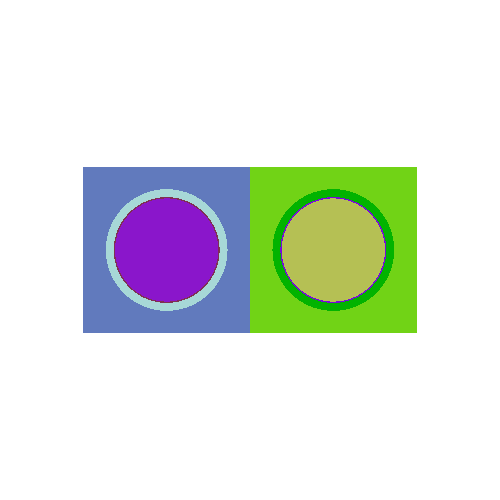

In [227]:
model.materials.export_to_xml()
model.geometry.export_to_xml()
plot = openmc.Plot.from_geometry(model.geometry)
plot.pixels = (500, 500)
plot.width = (3*pitch, 3*pitch)
plot.origin = (0., 0., 0)
plot.color_by = 'cell'
# plot.colors = {
#     water: 'blue',
#     zirconium: 'black',
#     helium: 'yellow',
#     uo2_in: (100, 0, 0),
#     uo2_out: (255, 0, 0)
# }
plot.to_ipython_image()

### Choose settings

In [228]:
source = openmc.IndependentSource()
source.space = openmc.stats.Point((0.,0.,0.))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([10.0e6], [1.0])
source.time = openmc.stats.Uniform(0, 1e-6)
settings = openmc.Settings()
settings.source = source
settings = openmc.Settings()
settings.source = source
settings.batches = 50
settings.inactive = 10
settings.particles = 100000
settings.output = {'tallies':True}
model.settings = settings
model.settings.export_to_xml()

### Define and choose energy group

In [229]:
choose_group=openmc.mgxs.GROUP_STRUCTURES['XMAS-172']
name_group='XMAS172'

### Create MGXS tallies for mgxs directory

In [230]:
mgxs_lib = openmc.mgxs.Library(model.geometry)
groups = openmc.mgxs.EnergyGroups(choose_group)
mgxs_lib.energy_groups = groups
mgxs_lib.scatter_format = "legendre"
mgxs_lib.legendre_order = 3
mgxs_lib.mgxs_types = ['total', 'absorption', 'fission', 'nu-fission', 'chi', 'scatter matrix', 'nu-scatter matrix', 'inverse-velocity']
mgxs_lib.tally_trigger =openmc.Trigger('std_dev', 1e-2)
mgxs_lib.by_nuclide = False
mgxs_lib.domain_type = 'cell'
mgxs_lib.domains = model.geometry.get_all_material_cells().values()
mgxs_lib.build_library()
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies, merge=True)
#tally_flux.merge_tallies()
model.tallies = tallies
#print(model.tallies)

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mgxs/library.py:401: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)


### Run OpenMC model

In [231]:
model.export_to_xml()
sp_file = model.run()
sp = openmc.StatePoint(sp_file)

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3216.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3012.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3020.
  warn(msg, IDWarning)


[Machine2:49613] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%

### Plot Flux

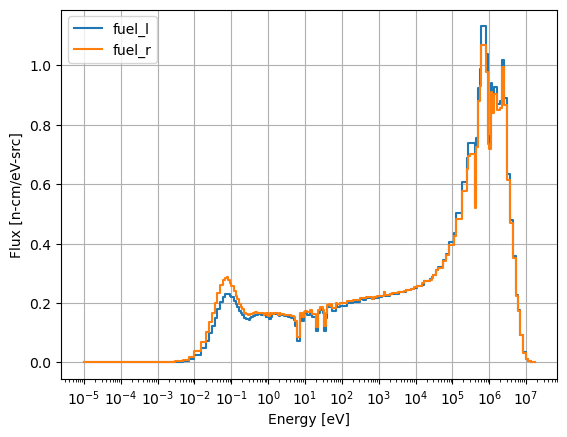

In [232]:
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import LogLocator

#Enter the name of the cell type string// example: fuel_out = openmc.Cell(name='fuel_out') ///
cell_plot=['fuel_l','fuel_r']#,'moderator_in']


sp = openmc.StatePoint(sp_file)
sp.tallies
tally_flux_id=[]
for index, tally in enumerate(sp.tallies):
    if sp.tallies[tally].scores==['flux']:
        t=sp.tallies[tally]

def flux_cell(cell):
    
    cell_index = 99
    cell_id=99
    # print(model.geometry.get_all_material_cells().values())
    i=0
    for all_cell in model.geometry.get_all_material_cells().values():
        i=i+1
        if all_cell.name==cell:
            cell_index=all_cell.id
            cell_id=i-1
            # print(cell_id)
            
    tally_data_reshaped =t.get_reshaped_data()
    flux=tally_data_reshaped[cell_id]
    
    liste_reduced = []
    for under_liste in flux:
        nombre = under_liste[0][0]
        liste_reduced.append(nombre)
    flux=liste_reduced
    return(flux)
    

dE=np.diff(choose_group)
Emid=choose_group[:-1]+dE/2

fig, ax = plt.subplots()
for i,cell in enumerate(cell_plot):
    flux=flux_cell(cell_plot[i])    
    mg_spectrum=flux #/ np.sum(flux)
    ax.step(choose_group[:-1], Emid*mg_spectrum/dE, where='post', label=cell_plot[i])
    
    
ax.set_xscale('log')

ax.xaxis.set_major_locator(FixedLocator(locs=np.logspace(-5, 7, 13)))
locmin=LogLocator(base=10,subs=np.linspace(0,1.0,11)[1:-1],numticks=1000)
ax.xaxis.set_minor_locator(locmin)
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n-cm/eV-src]')
ax.grid()
ax.legend()
plt.show()


### Print MGXS

In [233]:
mgxs_lib.load_from_statepoint(sp)
type(mgxs_lib)
reaction_print = 'total'
#Enter the name of the cell type openmc.Cell /// example: fuel_out = openmc.Cell(name='fuel_out') ///
cell_print=fuel_l
df_mgxs = mgxs_lib.get_mgxs(cell_print, reaction_print)
df_mgxs.print_xs()

Multi-Group XS
	Reaction Type  =	total
	Domain Type    =	cell
	Domain ID      =	133
	Cross Sections [cm^-1]:
            Group 1 [17332500.0 - 19640300.0eV]:	2.10e-01 +/- 4.23e+01%
            Group 2 [14918200.0 - 17332500.0eV]:	2.06e-01 +/- 2.04e+01%
            Group 3 [13840300.0 - 14918200.0eV]:	2.04e-01 +/- 1.65e+01%
            Group 4 [11618300.0 - 13840300.0eV]:	2.00e-01 +/- 4.78e+00%
            Group 5 [10000000.0 - 11618300.0eV]:	1.92e-01 +/- 3.58e+00%
            Group 6 [8187310.0  - 10000000.0eV]:	1.91e-01 +/- 1.76e+00%
            Group 7 [6703200.0  - 8187310.0 eV]:	1.97e-01 +/- 9.71e-01%
            Group 8 [6065310.0  - 6703200.0 eV]:	1.96e-01 +/- 8.72e-01%
            Group 9 [5488120.0  - 6065310.0 eV]:	2.23e-01 +/- 8.38e-01%
            Group 10 [4493290.0  - 5488120.0 eV]:	2.28e-01 +/- 5.27e-01%
            Group 11 [3678790.0  - 4493290.0 eV]:	2.73e-01 +/- 4.18e-01%
            Group 12 [3011940.0  - 3678790.0 eV]:	2.90e-01 +/- 3.09e-01%
            Group 13 [24

### Plot MGXS from mgxs directory

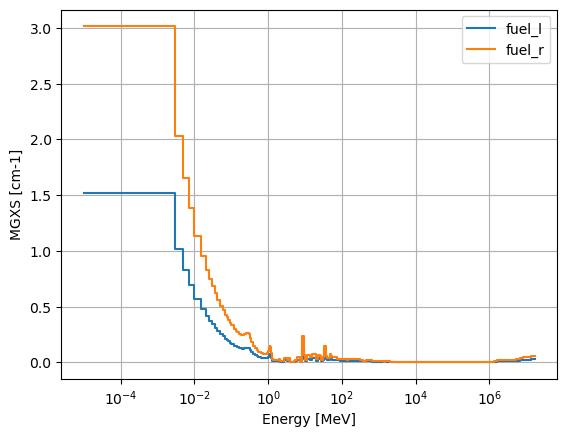

In [234]:
#Enter the name of the cell type openmc.Cell /// example: fuel_out = openmc.Cell(name='fuel_out') ///

reaction_plot = 'fission'
cell_plot_1 = fuel_l
cell_name_1='fuel_l'
cell_plot_2 = fuel_r
cell_name_2='fuel_r'


mgxs_plot_1 = mgxs_lib.get_mgxs(cell_plot_1, reaction_plot)

mgxs1=mgxs_plot_1.get_pandas_dataframe(xs_type='macro')['mean'].values
mgxs_plot_2 = mgxs_lib.get_mgxs(cell_plot_2, reaction_plot)
mgxs2=mgxs_plot_2.get_pandas_dataframe(xs_type='macro')['mean'].values


fig, ax = plt.subplots()
ax.step(choose_group[:-1], np.flip(mgxs1), where='post', label=cell_name_1) 
ax.step(choose_group[:-1], np.flip(mgxs2), where='post', label=cell_name_2) 


        
ax.set_xscale('log')

ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('MGXS [cm-1]')
ax.grid() 
# bbox = ax.get_position()
# ax.text(bbox.x1 - 0.05, bbox.y0 - 0.05, reaction_plot, fontsize=15, color='red', ha='right')
ax.legend()
plt.show()

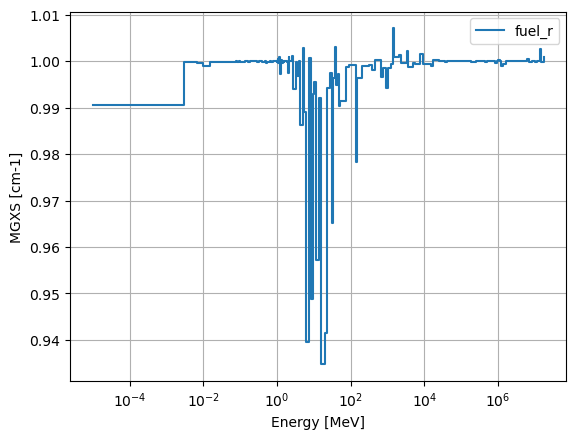

In [236]:
fig, ax = plt.subplots()
# ax.step(choose_group[:-1], np.flip(mgxs1), where='post', label=cell_name_1) 
ax.step(choose_group[:-1], np.flip(mgxs2)/np.flip(mgxs1)/2, where='post', label=cell_name_2) 


        
ax.set_xscale('log')

ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('MGXS [cm-1]')
ax.grid() 
# bbox = ax.get_position()
# ax.text(bbox.x1 - 0.05, bbox.y0 - 0.05, reaction_plot, fontsize=15, color='red', ha='right')
ax.legend()
plt.show()

